# 图片预处理

In [1]:
import os, shutil, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle 

%matplotlib inline 

## 工具函数:判断操作系统种类

In [2]:
print("当前工作目录是:")
print(os.getcwd())

当前工作目录是:
/home/ubuntu/cat_vs_dog_cnn


In [3]:
from PIL import Image
print(Image.__file__)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py


In [4]:
def is_Windows_OS():
    if platform.system() == 'Windows':
        return True
    else:
        return False

## 定义的目录结构变量

In [5]:
# 训练集图片从zip包解压之后存放的目录
train_images_folder = 'train'

# 训练集图片目录
train_set_folder = 'train1'
train_set_folder_cat = 'train1/cats/'
train_set_folder_dog = 'train1/dogs/'

# 验证集图片目录
validation_set_folder = 'valid'
validation_set_folder_cat = 'valid/cats/'
validation_set_folder_dog = 'valid/dogs/'

## 新建有关目录结构

In [6]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir(train_set_folder)
os.mkdir(train_set_folder_cat)
os.mkdir(train_set_folder_dog)

rmrf_mkdir(validation_set_folder)
os.mkdir(validation_set_folder_cat)
os.mkdir(validation_set_folder_dog)

## 加载训练集目录

In [7]:
train_filenames = os.listdir(train_images_folder)
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

In [8]:
print (type(train_cat))
print (len(train_filenames))

<class 'filter'>
25000


In [9]:
print (train_filenames[24999])

cat.2814.jpg


定义一组移动有用的函数：

In [10]:
num_of_images_valid_set = 2500
        
def move_cat_images():
    timer = 0
    for filename in train_cat:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_cat)
        else:
            shutil.copy2('train/'+filename, train_set_folder_cat)
        timer = timer + 1

def move_dog_images():
    timer = 0
    for filename in train_dog:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_dog)
        else:
            shutil.copy2('train/'+filename, train_set_folder_dog)
        timer = timer + 1  

In [11]:
def fill_train_set_valid_set_folder_with_images():
    move_cat_images()
    move_dog_images()

In [12]:
fill_train_set_valid_set_folder_with_images()
print ('fill_train_set_valid_set_folder_with_images执行完毕')

fill_train_set_valid_set_folder_with_images执行完毕


# 搭建并且编译模型

In [19]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [40]:
batch_size = 64
target_size = (299, 299)

# 不包含原有模型的全连接层
base_model = InceptionResNetV2(include_top=False, 
                             weights='imagenet',
                             input_shape = (299, 299, 3),
                             pooling='avg')

x = base_model.output

x = Dense(units = 1024, activation = 'relu',  name='fc1')(x)

x = Dropout(0.8, name='dropout')(x)

# Classifier
predictions = Dense(units = 1, activation='sigmoid',  name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("模型组装完毕！")

模型组装完毕！


## 可视化模型结构

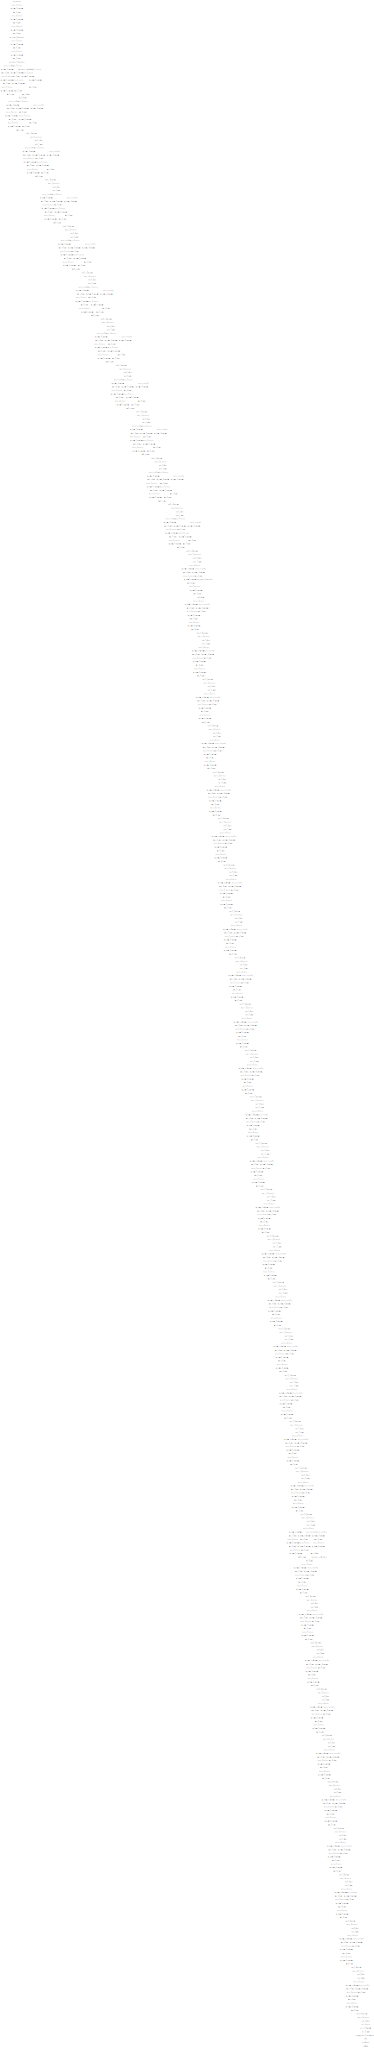

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 打印各层名称

In [46]:
for i in range(len(model.layers)):
    print(i,model.layers[i].name)

0 input_3
1 conv2d_407
2 batch_normalization_407
3 activation_407
4 conv2d_408
5 batch_normalization_408
6 activation_408
7 conv2d_409
8 batch_normalization_409
9 activation_409
10 max_pooling2d_9
11 conv2d_410
12 batch_normalization_410
13 activation_410
14 conv2d_411
15 batch_normalization_411
16 activation_411
17 max_pooling2d_10
18 conv2d_415
19 batch_normalization_415
20 activation_415
21 conv2d_413
22 conv2d_416
23 batch_normalization_413
24 batch_normalization_416
25 activation_413
26 activation_416
27 average_pooling2d_3
28 conv2d_412
29 conv2d_414
30 conv2d_417
31 conv2d_418
32 batch_normalization_412
33 batch_normalization_414
34 batch_normalization_417
35 batch_normalization_418
36 activation_412
37 activation_414
38 activation_417
39 activation_418
40 mixed_5b
41 conv2d_422
42 batch_normalization_422
43 activation_422
44 conv2d_420
45 conv2d_423
46 batch_normalization_420
47 batch_normalization_423
48 activation_420
49 activation_423
50 conv2d_419
51 conv2d_421
52 conv2d_42

## 编译模型

In [47]:
for layer in model.layers[:632]:
    layer.trainable = False
    
for layer in model.layers[632:]:
    layer.trainable = True

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("模型编译完成!")

模型编译完成!


## 训练模型

In [48]:
train_image_gen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
print("训练集图片:")
training_set = train_image_gen.flow_from_directory('train1',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')

valid_image_gen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)
print("验证集图片:")
validation_set = valid_image_gen.flow_from_directory('valid',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')


训练集图片:
Found 20000 images belonging to 2 classes.
验证集图片:
Found 5000 images belonging to 2 classes.


## 开始训练模型

In [49]:
# 训练集图片总量
train_size = 22000

# 每一轮训练需要执行的步长
steps_per_epoch = train_size/batch_size

# 验证集图片总量
valid_size = 3000
# 每一轮验证需要执行的步长
validation_steps = valid_size/batch_size

# 增加检查点，设置模型早停
callbacks = [EarlyStopping(monitor='val_loss', patience=5 ),
             ModelCheckpoint(filepath='final_model_weights.h5', monitor='val_loss', save_best_only=True)]

# 使用模型拟合图片数据
model.fit_generator(training_set, epochs = 10, steps_per_epoch = steps_per_epoch, callbacks=callbacks,
                    validation_data=validation_set, validation_steps = validation_steps)

Epoch 1/10
344/343 [==============================] - 566s 2s/step - loss: 0.0642 - acc: 0.9762 - val_loss: 0.0621 - val_acc: 0.9812
Epoch 2/10
344/343 [==============================] - 538s 2s/step - loss: 0.0380 - acc: 0.9871 - val_loss: 0.0192 - val_acc: 0.9916
Epoch 3/10
344/343 [==============================] - 543s 2s/step - loss: 0.0312 - acc: 0.9885 - val_loss: 0.0233 - val_acc: 0.9920
Epoch 4/10
344/343 [==============================] - 539s 2s/step - loss: 0.0254 - acc: 0.9908 - val_loss: 0.0211 - val_acc: 0.9942
Epoch 5/10
344/343 [==============================] - 543s 2s/step - loss: 0.0326 - acc: 0.9895 - val_loss: 0.0345 - val_acc: 0.9920
Epoch 6/10
344/343 [==============================] - 538s 2s/step - loss: 0.0253 - acc: 0.9906 - val_loss: 0.0355 - val_acc: 0.9902
Epoch 7/10
117/343 [=========>....................] - ETA: 4:36 - loss: 0.0165 - acc: 0.9939

KeyboardInterrupt: 

## 开始预测

In [50]:
# 测试集图片从zip包解压缩之后的存放目录
test_set_folder = 'test'
test_folder ="test1"
test_inner_folder = "test1/test"
rmrf_mkdir(test_folder)
os.mkdir(test_inner_folder)

In [51]:
def move_test_images():
    test_filenames = os.listdir(test_set_folder)
    for filename in test_filenames:
        shutil.copy2( test_set_folder + '/' + filename, test_inner_folder)


In [52]:
move_test_images()
print("开始导入测试集图片:")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_folder,
                                                  target_size=target_size, 
                                                  batch_size=batch_size,
                                                  shuffle = False, class_mode=None)

print("测试目录准备完成！")

开始导入测试集图片:
Found 12500 images belonging to 1 classes.
测试目录准备完成！


## 备份模型到`json`文件

In [53]:
from keras.models import model_from_json

# 保存模型结构
model_json = model.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)
    
print("模型已经保存到json文件！")

模型已经保存到json文件！


# 加载模型结构和权重

In [54]:
# 使用新的模型结构加载模型权重
json_file = open("best_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("loaded_model重新加载模型权重！")
loaded_model.load_weights('final_model_weights.h5')
print("loaded_model重新加载模型权重完成！")

loaded_model重新加载模型权重！
loaded_model重新加载模型权重完成！


In [55]:
print("预测执行开始！")
pred_result = loaded_model.predict_generator(test_generator, verbose=1)
print("预测执行完毕！")

预测执行开始！
196/196 [==============================] - 63s 320ms/step
预测执行完毕！


In [56]:
test_generator.filenames[:10]

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg',
 'test/10001.jpg',
 'test/10002.jpg',
 'test/10003.jpg',
 'test/10004.jpg',
 'test/10005.jpg']

In [57]:
pred_result[:10]

array([[1.0000000e+00],
       [7.6395175e-08],
       [4.3094664e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.2615536e-14],
       [2.6570581e-06],
       [9.9999809e-01],
       [1.0000000e+00],
       [1.3670490e-19]], dtype=float32)

## 导出预测结果

In [58]:
import pandas as pd
from keras.preprocessing.image import *

solution = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        solution.set_value(index-1, 'label', pred_result[i])

print("导出结果完成！")

导出结果完成！


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [59]:
solution.to_csv("pred-19.csv", index = False)
solution.head(10)

,id,label
0,1,1.000000e+00
1,2,1.000000e+00
2,3,9.999999e-01
3,4,9.999812e-01
4,5,1.821770e-04
5,6,1.061645e-06
6,7,1.292124e-21
7,8,5.144050e-14
8,9,1.988698e-13
9,10,7.639517e-08
